# SILO API Simple Interface Examples

This notebook demonstrates the simple, high-level interface methods in the SILO API client. These methods provide an easy way to access Australian climate data without needing to work with complex Pydantic models.

## Available Simple Methods

- `get_patched_point()` - Get PatchedPoint data (weather station data with infilled gaps)
- `get_data_drill()` - Get DataDrill data (interpolated gridded data for any coordinates)
- `search_stations()` - Search for weather stations by name or state
- `get_recent_data()` - Quick access to recent data (last N days)

**Dataset Terminology:**
- **PatchedPoint**: Weather station observational data with missing values interpolated from nearby stations
- **DataDrill**: Gridded data at 0.05° × 0.05° resolution (~5km) interpolated across Australia

## Setup

First, let's import the required libraries and set up our API client.

In [1]:
import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the SILO API client
from weather_tools.silo_api import SiloAPI

# Set up plotting style
plt.style.use("default")
plt.rcParams["figure.figsize"] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Initialize the API client
# Note: You need to set your SILO_API_KEY environment variable or provide your email as api_key
# For this example, we'll use a placeholder - replace with your actual email

try:
    # Try to use environment variable first
    api = SiloAPI()  # Uses SILO_API_KEY environment variable
    print("✅ API client initialized using SILO_API_KEY environment variable")
except ValueError:
    # If no environment variable, use a placeholder (you should replace this with your email)
    api = SiloAPI(api_key="your_email@example.com")  # Replace with your email
    print("⚠️  API client initialized with placeholder email - replace with your actual email")
    print("   Set SILO_API_KEY environment variable or update the api_key parameter above")

✅ API client initialized using SILO_API_KEY environment variable


 ## 1. Searching for Weather Stations



 Let's start by finding weather stations. The `search_stations()` method makes it easy to find stations by name or state.

In [3]:
# Search for stations containing "Brisbane" in the name
brisbane_stations = api.search_stations(name_fragment="Brisbane")

print(f"Found {len(brisbane_stations)} stations with 'Brisbane' in the name:")
print("\nFirst 10 stations:")
print(brisbane_stations.head(10).to_string(index=False))

Found 7 stations with 'Brisbane' in the name:

First 10 stations:
 station_code                       name  latitude  longitude state  elevation
        40913                   BRISBANE   -27.481    153.039   QLD        8.1
        40223              BRISBANE AERO   -27.418    153.114   QLD        4.0
        40842              BRISBANE AERO   -27.392    153.129   QLD        4.5
        40216      BRISBANE SHOW GROUNDS   -27.451    153.033   QLD       16.0
        40214   BRISBANE REGIONAL OFFICE   -27.478    153.031   QLD       38.0
        40215 BRISBANE BOTANICAL GARDENS   -27.483    153.033   QLD       15.0
        40140                MT BRISBANE   -27.149    152.578   QLD      100.0


In [4]:
# Let's pick a specific Brisbane station for our examples
# Brisbane Airport is station 30043 - a well-known station with good data coverage
selected_station = "30043"
station_info = brisbane_stations.iloc[0]

station_name = station_info["name"]
station_lat = station_info["latitude"]
station_lon = station_info["longitude"]
print(f"Selected station: {station_name} (Code: {selected_station})")
print(f"Location: {station_lat}°S, {station_lon}°E")

Selected station: BRISBANE (Code: 30043)
Location: -27.481°S, 153.039°E


## 2. Getting Weather Station Data (PatchedPoint)

Now let's get some historical weather station data for our selected station using the `get_patched_point()` method.

In [6]:
# Get weather data for January 2023
start_date = "20230101"
end_date = "20230131"
variables = ["daily_rain", "max_temp", "min_temp"]

print(f"Getting weather data for station {selected_station} ({station_name})")
print(f"Date range: {start_date} to {end_date}")
print(f"Variables: {variables}")

# Get the data
station_data = api.get_patched_point(
    station_code=selected_station, start_date=start_date, end_date=end_date, variables=variables
)

print(f"\n📊 Retrieved {len(station_data)} days of data")
print("\nFirst 5 rows:")
print(station_data.head())

Getting weather data for station 30043 (BRISBANE)
Date range: 20230101 to 20230131
Variables: ['daily_rain', 'max_temp', 'min_temp']

📊 Retrieved 31 days of data

First 5 rows:
   station  daily_rain  daily_rain_source  max_temp  max_temp_source  \
0    30043         0.0                 25      37.4               25   
1    30043         3.2                 25      35.3               25   
2    30043         9.3                 25      35.2               25   
3    30043         0.8                 25      35.3               25   
4    30043         4.4                 25      34.7               25   

   min_temp  min_temp_source       date  \
0      24.7               25 2023-01-01   
1      23.8               25 2023-01-02   
2      23.8               25 2023-01-03   
3      24.1               25 2023-01-04   
4      24.2               25 2023-01-05   

                                            metadata  
0  {"name": "PROA STATION", "latitude": "-20.8944...  
1                    

In [7]:
# Let's also get the data with metadata to see what information is included
station_data_with_meta, metadata = api.get_patched_point(
    station_code=selected_station,
    start_date=start_date,
    end_date=end_date,
    variables=variables,
    return_metadata=True,
)

print("Metadata information:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

Metadata information:
  station_code: 30043
  date_range: {'start': '20230101', 'end': '20230131'}
  variables: ['daily_rain', 'max_temp', 'min_temp']
  format: csv
  dataset: PatchedPoint


 ## 3. Visualizing Station Data



 Let's create some plots to visualize the weather data we retrieved.

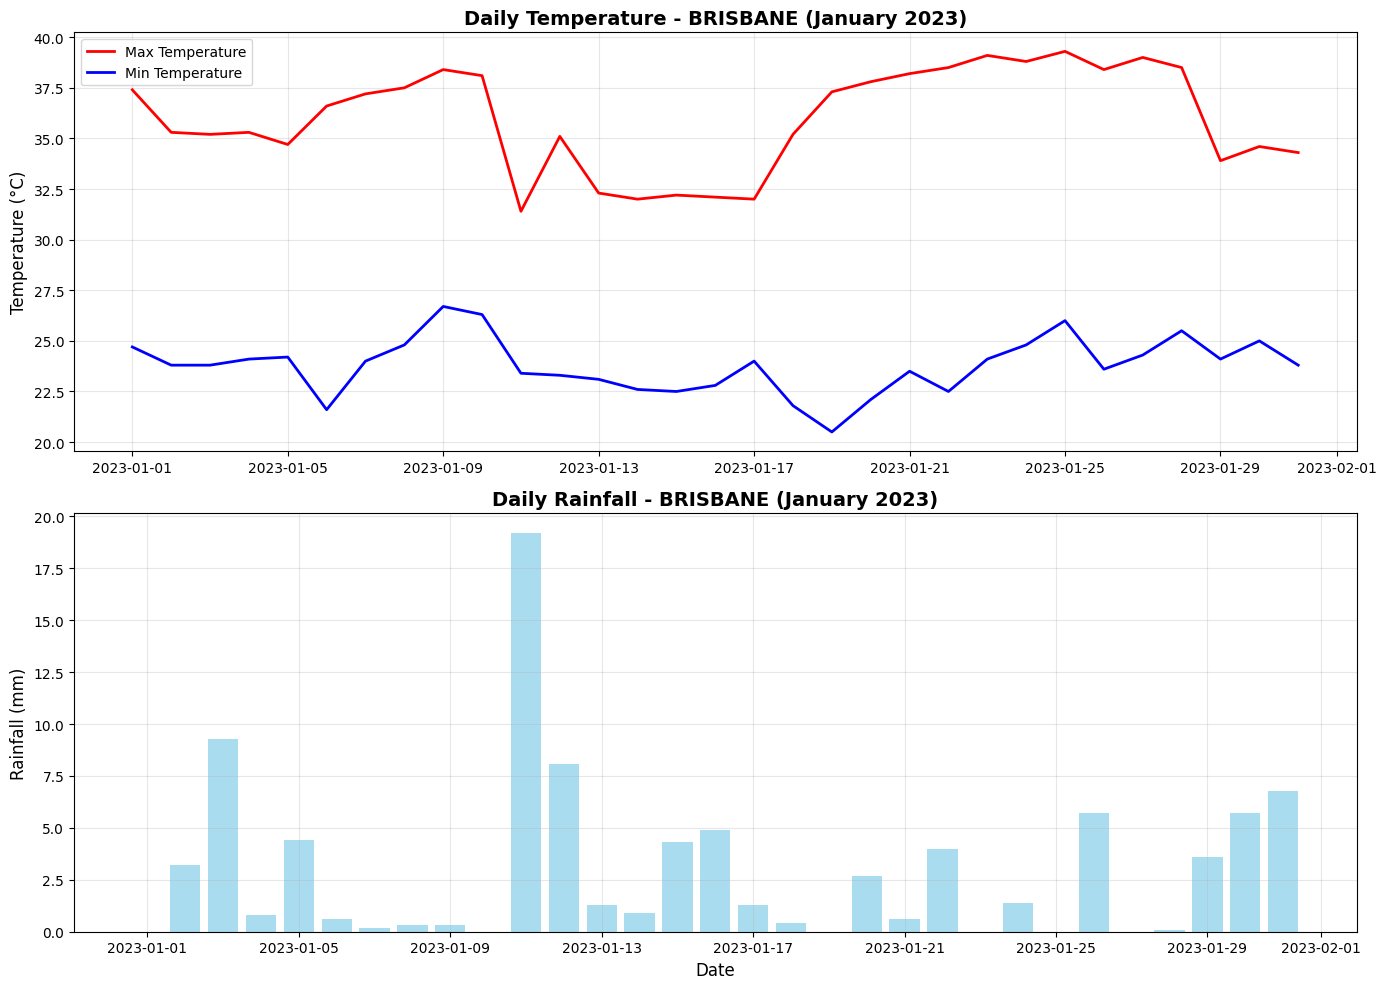


📈 Basic Statistics:
       station  daily_rain  daily_rain_source   max_temp  max_temp_source  \
count     31.0   31.000000               31.0  31.000000             31.0   
mean   30043.0    2.906452               25.0  35.990323             25.0   
min    30043.0    0.000000               25.0  31.400000             25.0   
25%    30043.0    0.250000               25.0  34.450000             25.0   
50%    30043.0    1.300000               25.0  36.600000             25.0   
75%    30043.0    4.350000               25.0  38.300000             25.0   
max    30043.0   19.200000               25.0  39.300000             25.0   
std        0.0    4.026325                0.0   2.530264              0.0   

        min_temp  min_temp_source                 date  
count  31.000000             31.0                   31  
mean   23.783871             25.0  2023-01-16 00:00:00  
min    20.500000             25.0  2023-01-01 00:00:00  
25%    22.950000             25.0  2023-01-08 12:00:00  


In [8]:
# Create plots for the station data
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Convert date column to datetime if it's not already
station_data["date"] = pd.to_datetime(station_data["date"])


# Plot 1: Temperature

axes[0].plot(
    station_data["date"], station_data["max_temp"], "r-", label="Max Temperature", linewidth=2
)
axes[0].plot(
    station_data["date"], station_data["min_temp"], "b-", label="Min Temperature", linewidth=2
)

axes[0].set_title(
    f"Daily Temperature - {station_name} (January 2023)", fontsize=14, fontweight="bold"
)
axes[0].set_ylabel("Temperature (°C)", fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Rainfall
rain_cols = [col for col in station_data.columns if "rain" in col.lower() or "R_" in col]
if rain_cols:
    rain_col = rain_cols[0]
    axes[1].bar(station_data["date"], station_data[rain_col], color="skyblue", alpha=0.7, width=0.8)
    axes[1].set_title(
        f"Daily Rainfall - {station_name} (January 2023)", fontsize=14, fontweight="bold"
    )
    axes[1].set_ylabel("Rainfall (mm)", fontsize=12)
    axes[1].set_xlabel("Date", fontsize=12)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some basic statistics
print("\n📈 Basic Statistics:")
print(station_data.describe())

## 4. Getting DataDrill Data for Any Coordinates

The `get_data_drill()` method allows you to get interpolated climate data for any latitude/longitude coordinates, even where there's no weather station. This uses SILO's DataDrill dataset.

In [9]:
# Let's get gridded data for a location near our station
# Using coordinates close to Brisbane Airport but slightly different
target_lat = -27.5
target_lon = 153.0

print(f"Getting gridded climate data for coordinates: {target_lat}°S, {target_lon}°E")
print(f"Date range: {start_date} to {end_date}")
print(f"Variables: {variables}")

# Get gridded data
gridded_data = api.get_data_drill(
    latitude=target_lat,
    longitude=target_lon,
    start_date=start_date,
    end_date=end_date,
    variables=variables,
)

print(f"\n📊 Retrieved {len(gridded_data)} days of gridded data")
print("\nFirst 5 rows:")
print(gridded_data.head())

Getting gridded climate data for coordinates: -27.5°S, 153.0°E
Date range: 20230101 to 20230131
Variables: ['daily_rain', 'max_temp', 'min_temp']

📊 Retrieved 31 days of gridded data

First 5 rows:
   latitude  longitude  daily_rain  daily_rain_source  max_temp  \
0     -27.5      153.0         0.2                 25      29.1   
1     -27.5      153.0         0.0                 25      29.5   
2     -27.5      153.0         0.0                 25      31.7   
3     -27.5      153.0         0.0                 25      32.7   
4     -27.5      153.0        37.3                 25      27.7   

   max_temp_source  min_temp  min_temp_source       date  \
0               25      19.4               25 2023-01-01   
1               25      18.2               25 2023-01-02   
2               25      17.3               25 2023-01-03   
3               25      19.8               25 2023-01-04   
4               25      21.8               25 2023-01-05   

                                      

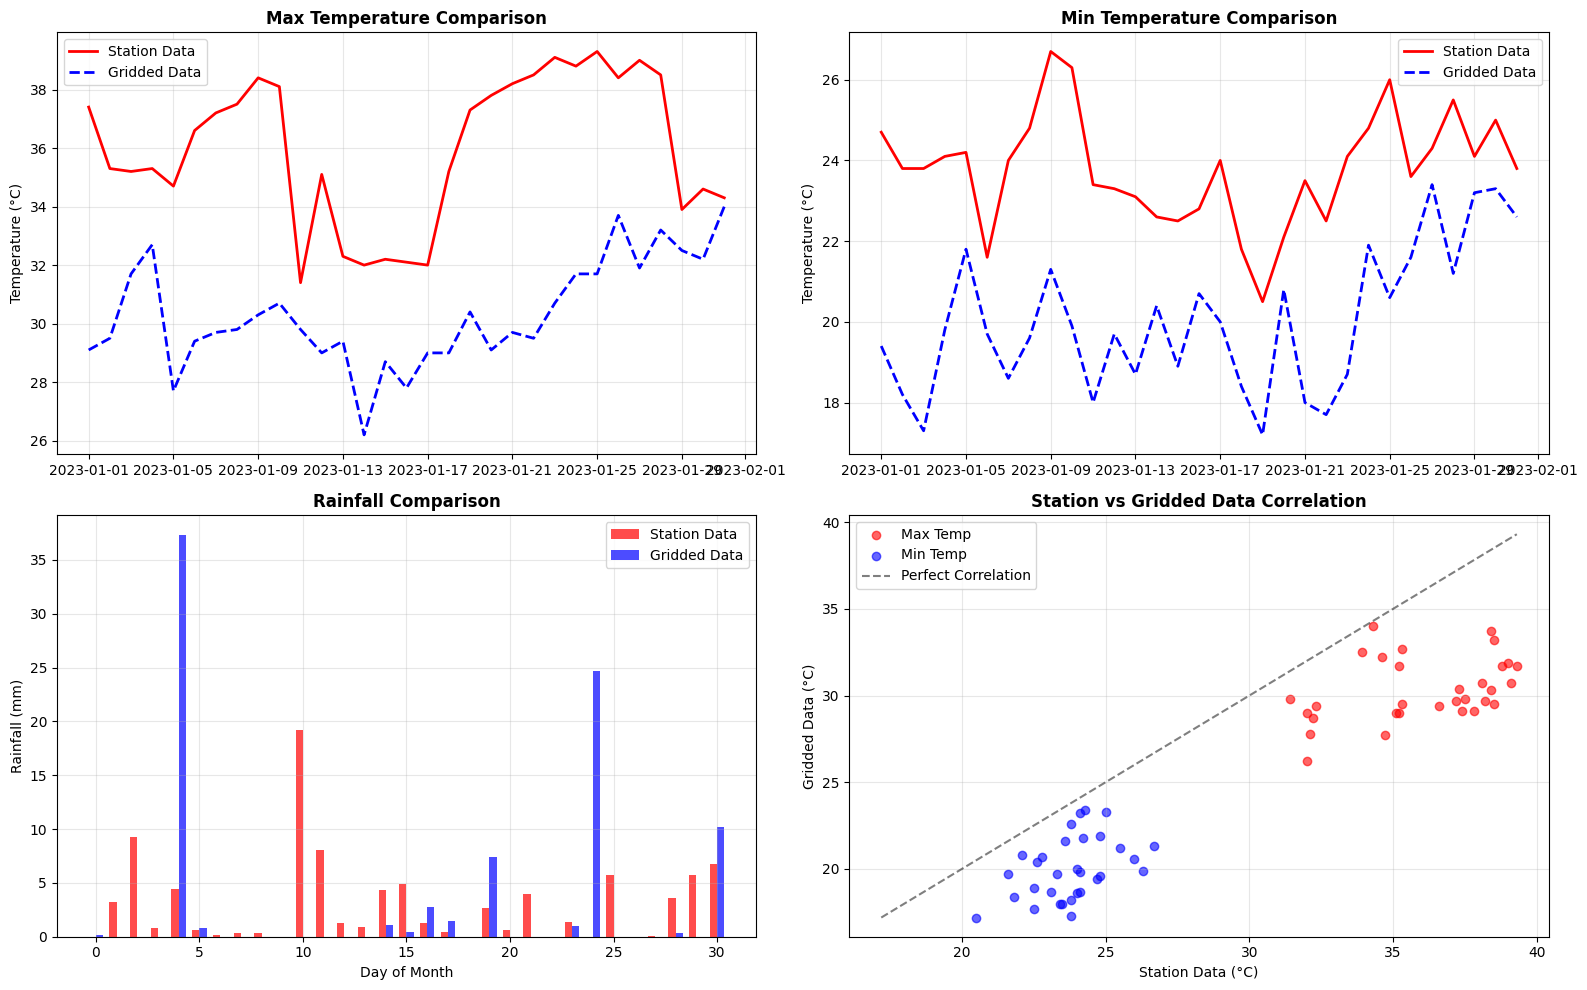


📊 Data source comparison completed!
Station location: -27.481°S, 153.039°E
Gridded location: -27.5°S, 153.0°E
Distance: ~4.8 km


In [10]:
# Compare station data vs gridded data
fig, axes = plt.subplots(2, 2, figsize=(16, 10))


# Helper function to find temperature and rainfall columns
def find_columns(df, pattern):
    return [col for col in df.columns if any(p in col.lower() for p in pattern)]


# Find date columns for both datasets
date_col = "date"
max_temp = "max_temp"
min_temp = "min_temp"

# Ensure dates are datetime
station_data[date_col] = pd.to_datetime(station_data[date_col])
gridded_data[date_col] = pd.to_datetime(gridded_data[date_col])


# Plot max temperature comparison
axes[0, 0].plot(
    station_data[date_col], station_data[max_temp], "r-", label="Station Data", linewidth=2
)
axes[0, 0].plot(
    gridded_data[date_col], gridded_data[max_temp], "b--", label="Gridded Data", linewidth=2
)
axes[0, 0].set_title("Max Temperature Comparison", fontweight="bold")
axes[0, 0].set_ylabel("Temperature (°C)")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot min temperature comparison
axes[0, 1].plot(
    station_data[date_col], station_data[min_temp], "r-", label="Station Data", linewidth=2
)
axes[0, 1].plot(
    gridded_data[date_col], gridded_data[min_temp], "b--", label="Gridded Data", linewidth=2
)
axes[0, 1].set_title("Min Temperature Comparison", fontweight="bold")
axes[0, 1].set_ylabel("Temperature (°C)")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)


width = 0.35
x = np.arange(len(station_data))

axes[1, 0].bar(
    x - width / 2, station_data["daily_rain"], width, label="Station Data", color="red", alpha=0.7
)
axes[1, 0].bar(
    x + width / 2, gridded_data["daily_rain"], width, label="Gridded Data", color="blue", alpha=0.7
)
axes[1, 0].set_title("Rainfall Comparison", fontweight="bold")
axes[1, 0].set_ylabel("Rainfall (mm)")
axes[1, 0].set_xlabel("Day of Month")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot showing correlation
axes[1, 1].scatter(
    station_data[max_temp], gridded_data[max_temp], alpha=0.6, color="red", label="Max Temp"
)
axes[1, 1].scatter(
    station_data[min_temp], gridded_data[min_temp], alpha=0.6, color="blue", label="Min Temp"
)

# Add diagonal line for perfect correlation
min_temp = min(station_data[min_temp].min(), gridded_data[min_temp].min())
max_temp = max(station_data[max_temp].max(), gridded_data[max_temp].max())
axes[1, 1].plot(
    [min_temp, max_temp], [min_temp, max_temp], "k--", alpha=0.5, label="Perfect Correlation"
)
axes[1, 1].set_title("Station vs Gridded Data Correlation", fontweight="bold")
axes[1, 1].set_xlabel("Station Data (°C)")
axes[1, 1].set_ylabel("Gridded Data (°C)")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Data source comparison completed!")
print(f"Station location: {station_lat}°S, {station_lon}°E")
print(f"Gridded location: {target_lat}°S, {target_lon}°E")
print(
    f"Distance: ~{((station_lat - target_lat) ** 2 + (station_lon - target_lon) ** 2) ** 0.5 * 111:.1f} km"
)

 ## 5. Getting Recent Data



 The `get_recent_data()` method provides a quick way to get recent weather data for the last N days.

In [11]:
# Get recent data for our selected station (last 7 days)
print(f"Getting recent data (last 7 days) for station {selected_station}")
recent_station_data = api.get_recent_data(
    station_code=selected_station, days=7, variables=["rainfall", "max_temp", "min_temp"]
)

print(f"📊 Retrieved {len(recent_station_data)} days of recent station data")
print("\nRecent station data:")
print(recent_station_data.head(10))

Getting recent data (last 7 days) for station 30043


ValueError: Unknown variables: ['rainfall']. Valid names: cloud_fraction, daily_rain, et_morton_actual, et_morton_potential, et_morton_wet, et_short_crop, et_tall_crop, evap_comb, evap_morton_lake, evap_pan, evap_syn, max_temp, min_temp, monthly_rain, mslp, radiation, rh_tmax, rh_tmin, vp, vp_deficit, weather_symbol, wind_speed, wind_speed_max

In [13]:
# Get recent gridded data for our coordinates
print(f"\nGetting recent gridded data (last 7 days) for {target_lat}°S, {target_lon}°E")
recent_gridded_data = api.get_recent_data(
    latitude=target_lat,
    longitude=target_lon,
    days=7,
    variables=["daily_rain", "max_temp", "min_temp"],
)

print(f"📊 Retrieved {len(recent_gridded_data)} days of recent gridded data")
print("\nRecent gridded data:")
print(recent_gridded_data.head(10))


Getting recent gridded data (last 7 days) for -27.5°S, 153.0°E
📊 Retrieved 7 days of recent gridded data

Recent gridded data:
   latitude  longitude  daily_rain  daily_rain_source  max_temp  \
0     -27.5      153.0         2.9                 25      28.3   
1     -27.5      153.0        21.9                 25      30.7   
2     -27.5      153.0        14.7                 25      28.0   
3     -27.5      153.0         1.4                 25      33.4   
4     -27.5      153.0         0.0                 25      27.5   
5     -27.5      153.0         0.0                 25      28.9   
6     -27.5      153.0         0.0                 25      28.0   

   max_temp_source  min_temp  min_temp_source       date  \
0               25      18.8               25 2025-11-14   
1               25      18.9               25 2025-11-15   
2               25      20.9               25 2025-11-16   
3               25      20.2               25 2025-11-17   
4               25      15.9       

 ## 6. Data Processing and Analysis



 Let's perform some basic analysis on our data to show how easy it is to work with the DataFrames returned by the API.

 ## 7. Advanced Usage Tips



 Here are some advanced tips for using the SILO API simple interface methods effectively.

In [14]:
# Tip 1: Getting all available variables
print("💡 TIP 1: Getting all available climate variables")
print("=" * 50)

# When variables=None, all available variables are retrieved
all_vars_data = api.get_patched_point(
    station_code=selected_station,
    start_date="20230101",
    end_date="20230105",  # Just a few days to keep output manageable
    variables=None,  # This gets ALL available variables
)

print(f"Available columns when variables=None:")
for i, col in enumerate(all_vars_data.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nDataFrame shape: {all_vars_data.shape[0]} rows × {all_vars_data.shape[1]} columns")

💡 TIP 1: Getting all available climate variables
Available columns when variables=None:
   1. station
   2. daily_rain
   3. daily_rain_source
   4. max_temp
   5. max_temp_source
   6. min_temp
   7. min_temp_source
   8. evap_pan
   9. evap_pan_source
  10. radiation
  11. radiation_source
  12. vp
  13. vp_source
  14. date
  15. metadata

DataFrame shape: 5 rows × 15 columns


In [15]:
# Tip 2: Working with different time periods
print("\n💡 TIP 2: Working with different time periods")
print("=" * 50)

# Get data for different months to compare
months_data = {}
months = [("January", "20230101", "20230131"), ("July", "20230701", "20230731")]

for month_name, start, end in months:
    try:
        month_data = api.get_patched_point(
            station_code=selected_station,
            start_date=start,
            end_date=end,
            variables=["max_temp", "min_temp", "rainfall"],
        )
        months_data[month_name] = month_data
        print(f"{month_name} 2023: {len(month_data)} days of data retrieved")
    except Exception as e:
        print(f"Error getting {month_name} data: {e}")

# Compare the months
if len(months_data) == 2:
    jan_data = months_data["January"]
    jul_data = months_data["July"]

    jan_max_col = (
        find_columns(jan_data, ["max", "T_max"])[0]
        if find_columns(jan_data, ["max", "T_max"])
        else None
    )
    jul_max_col = (
        find_columns(jul_data, ["max", "T_max"])[0]
        if find_columns(jul_data, ["max", "T_max"])
        else None
    )

    if jan_max_col and jul_max_col:
        print(f"\nSeasonal comparison:")
        print(f"  January average max temp: {jan_data[jan_max_col].mean():.1f}°C")
        print(f"  July average max temp: {jul_data[jul_max_col].mean():.1f}°C")
        print(
            f"  Seasonal difference: {jan_data[jan_max_col].mean() - jul_data[jul_max_col].mean():.1f}°C"
        )


💡 TIP 2: Working with different time periods
Error getting January data: Unknown variables: ['rainfall']. Valid names: cloud_fraction, daily_rain, et_morton_actual, et_morton_potential, et_morton_wet, et_short_crop, et_tall_crop, evap_comb, evap_morton_lake, evap_pan, evap_syn, max_temp, min_temp, monthly_rain, mslp, radiation, rh_tmax, rh_tmin, vp, vp_deficit, weather_symbol, wind_speed, wind_speed_max
Error getting July data: Unknown variables: ['rainfall']. Valid names: cloud_fraction, daily_rain, et_morton_actual, et_morton_potential, et_morton_wet, et_short_crop, et_tall_crop, evap_comb, evap_morton_lake, evap_pan, evap_syn, max_temp, min_temp, monthly_rain, mslp, radiation, rh_tmax, rh_tmin, vp, vp_deficit, weather_symbol, wind_speed, wind_speed_max


In [16]:
# Tip 3: Error handling and data validation
print("\n💡 TIP 3: Error handling and data validation")
print("=" * 50)


def safe_get_patched_point(api, station_code, start_date, end_date, variables=None):
    """
    Safely get PatchedPoint station data with error handling and validation.
    """
    try:
        data = api.get_patched_point(
            station_code=station_code, start_date=start_date, end_date=end_date, variables=variables
        )

        # Validate the data
        if data.empty:
            print(f"⚠️ Warning: No data returned for station {station_code}")
            return None

        # Check for missing values
        missing_data = safe_data.drop(columns="metadata").isnull().sum()
        if missing_data.any():
            print(f"📊 Data quality report for station {station_code}:")
            for col, missing_count in missing_data.items():
                if missing_count > 0:
                    percentage = (missing_count / len(data)) * 100
                    print(f"   {col}: {missing_count} missing values ({percentage:.1f}%)")
        else:
            print(f"✅ Data quality: No missing values found")

        return data

    except Exception as e:
        print(f"❌ Error getting data for station {station_code}: {e}")
        return None


# Test the safe function
safe_data = safe_get_patched_point(
    api, selected_station, "20230101", "20230131", ["rainfall", "max_temp"]
)

if safe_data is not None:
    print(f"Successfully retrieved {len(safe_data)} days of data")


💡 TIP 3: Error handling and data validation
❌ Error getting data for station 30043: Unknown variables: ['rainfall']. Valid names: cloud_fraction, daily_rain, et_morton_actual, et_morton_potential, et_morton_wet, et_short_crop, et_tall_crop, evap_comb, evap_morton_lake, evap_pan, evap_syn, max_temp, min_temp, monthly_rain, mslp, radiation, rh_tmax, rh_tmin, vp, vp_deficit, weather_symbol, wind_speed, wind_speed_max
